In [4]:
import yfinance as yf
import pandas as pd

def get_stock_data(ticker, start_date, end_date):
    stock = yf.download(ticker, start=start_date, end=end_date)
    return stock

def save_to_csv(data, filename):
    data.to_csv(filename, index=True)

# 设置起始和结束日期
start_date = "2018-10-13"
end_date = "2023-10-18"

# 选择股票符号（可以根据需要添加或更改）
stocks = [ "ATVI"]  # 添加其他50个主要科技股票

# 创建一个空的DataFrame来存储所有数据
all_data = pd.DataFrame()

# 循环获取每支股票的数据并合并到all_data中
for stock_symbol in stocks:
    stock_data = get_stock_data(stock_symbol, start_date, end_date)
    stock_data["Symbol"] = stock_symbol  # 添加股票符号列
    
    all_data = pd.concat([all_data, stock_data], axis=0)

# 重新设置索引以包括日期列
all_data.reset_index(inplace=True)

# 保存数据到CSV文件
save_to_csv(all_data, "atvi_stock_data.csv")


[*********************100%%**********************]  1 of 1 completed


考虑到夜间的情绪传播会对第二天的开盘价造成影响，故选择收盘价进行绘图。

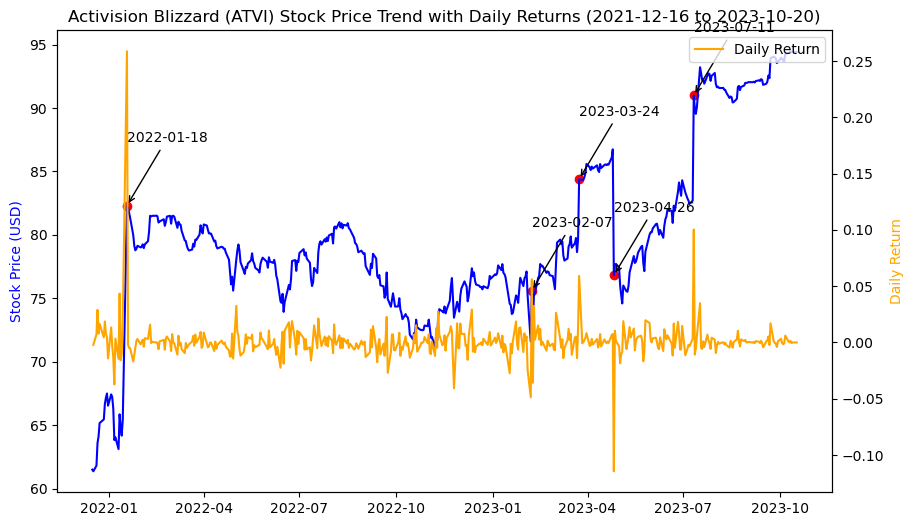

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取包含Activision Blizzard（ATVI）股票数据的CSV文件
atvi_data = pd.read_csv("tech_stock_data.csv", parse_dates=["Date"])
atvi_data = atvi_data[atvi_data["Symbol"] == "ATVI"]  # 仅选择ATVI的数据
atvi_data = atvi_data.set_index("Date")

# 筛选日期范围
start_date = "2021-12-16"
end_date = "2023-10-20"
atvi_data = atvi_data.loc[start_date:end_date]

# 计算每日收益率（即斜率）
atvi_data["Daily_Return"] = atvi_data["Close"].pct_change()

# 设置阈值以检测剧烈变化的点
threshold = 0.05  # 可根据需要调整

# 找到斜率剧烈变化的点
change_points = atvi_data[atvi_data["Daily_Return"].abs() > threshold]

# 绘制股票价格走势图和每日收益率
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(atvi_data.index, atvi_data["Close"], label="ATVI", color="blue")
ax1.scatter(change_points.index, change_points["Close"], color="red", label="Change Points")
ax1.set_ylabel("Stock Price (USD)", color="blue")
ax2 = ax1.twinx()
ax2.plot(atvi_data.index, atvi_data["Daily_Return"], label="Daily Return", color="orange")
ax2.set_ylabel("Daily Return", color="orange")

# 在图表上标注斜率变化的日期
for index, row in change_points.iterrows():
    ax1.annotate(f'{index.strftime("%Y-%m-%d")}', xy=(index, row['Close']), xytext=(index, row['Close'] + 5),
                 arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.title("Activision Blizzard (ATVI) Stock Price Trend with Daily Returns (2021-12-16 to 2023-10-20)")
plt.xlabel("Date")
plt.legend()
plt.show()


该图绘制了ATIV的股票价格数据，标记出了几个变动较大的点，例如1.18是微软宣布收购消息，4.26英国反垄断机构否决收购。
由于twitter和Facebook有api限制，爬虫难度较大，故选择了reddit社交平台爬取数据。
下面的代码将以“ATVI”为关键字、2023-04-26为日期进行搜索，爬取了相关帖子的评论。

In [11]:
#仅爬取帖子的标题和时间
import praw
import csv
from datetime import datetime
from datetime import datetime, timedelta

def main():

#需要输入密钥
    reddit = praw.Reddit(
        client_id='ZkoMe5kROotKebzy_Xch7g',
        #需要输入密钥
        client_secret='_zlqflZGNevCIbDtGmsO_AQCmtIBgA',
        user_agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36 Edg/119.0.0.0 '
    )


    # 使用关键字搜索 Reddit 上的帖子
    keyword = 'ATVI'
    search_results = reddit.subreddit("all").search(keyword, sort='relevance', time_filter='all')

    # 创建 CSV 文件并写入标题和发布时间
    csv_filename = f'reddit_posts_{keyword}.csv'
    with open(csv_filename, mode='w', newline='', encoding='utf-8-sig') as file:
        writer = csv.writer(file)
        writer.writerow(['Submission Title', 'Post Time'])  # 写入列名
        
        start_date = datetime(2023, 4, 25)
        end_date = datetime(2023, 4, 28) + timedelta(days=1)
        # 遍历搜索结果中的帖子并获取标题和发布时间
        post_count = 0  # 计数器
        for submission in search_results:
            if submission.stickied:  # 跳过置顶的帖子
                continue

            post_time = datetime.utcfromtimestamp(submission.created_utc)
            if start_date <= post_time < end_date:
                submission_title = submission.title

                # 写入帖子标题和发布时间
                writer.writerow([submission_title, post_time])

                post_count += 1
                # 控制帖子数量
                if post_count >= 1000:
                    break

if __name__ == "__main__":
    main()


In [ ]:
#爬取帖子的评论, keyword = 'CMA'
import praw
import csv
from datetime import datetime, timedelta

def write_comments_to_csv(comment, submission_title, submission_time, writer):
    if hasattr(comment, 'author'):  # 判断评论是否是真实的评论对象
        writer.writerow([submission_title, submission_time, datetime.utcfromtimestamp(comment.created_utc), comment.body])

    for reply in comment.replies:
        if isinstance(reply, praw.models.Comment):  # 判断是否是真实的评论对象
            write_comments_to_csv(reply, submission_title, submission_time, writer)
        elif isinstance(reply, praw.models.MoreComments):  # 处理 'MoreComments' 对象
            write_more_comments_to_csv(reply, submission_title, submission_time, writer)

def write_more_comments_to_csv(more_comments, submission_title, submission_time, writer):
    for comment in more_comments.comments():
        if isinstance(comment, praw.models.Comment):
            write_comments_to_csv(comment, submission_title, submission_time, writer)

def main():
    #需要输入密钥
    reddit = praw.Reddit(
        client_id='ZkoMe5kROotKebzy_Xch7g',
        #需要输入密钥
        client_secret='_zlqflZGNevCIbDtGmsO_AQCmtIBgA',
        user_agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36 Edg/119.0.0.0 '
    )
    # 使用关键字搜索 Reddit 上的帖子
    keyword = 'CMA'
    search_results = reddit.subreddit("all").search(keyword, sort='relevance', time_filter='all')

    # 创建 CSV 文件并写入标题、发布时间和评论
    csv_filename = f'reddit_comments_{keyword}_filtered.csv'
    with open(csv_filename, mode='w', newline='', encoding='utf-8-sig') as file:
        writer = csv.writer(file)
        writer.writerow(['Submission Title', 'Submission Time', 'Comment Time', 'Comment'])  # 写入列名

        # 计算开始日期和结束日期
        start_date = datetime(2023, 4, 25)
        end_date = datetime(2023, 4, 28) + timedelta(days=1)
        
        post_count = 0  # 计数器
        # 遍历搜索结果中的帖子并获取标题、发布时间和评论
        for submission in search_results:
            if submission.stickied:  # 跳过置顶的帖子
                continue

            submission_time = datetime.utcfromtimestamp(submission.created_utc)

            # 仅筛选发布时间在指定日期范围内的帖子
            if start_date <= submission_time < end_date:
                submission_title = submission.title

                # 遍历帖子下的所有评论并写入
                for top_level_comment in submission.comments:
                    if isinstance(top_level_comment, praw.models.Comment):
                        write_comments_to_csv(top_level_comment, submission_title, submission_time, writer)
                post_count += 1
                # 控制帖子数量
                if post_count >= 10:
                    break
if __name__ == "__main__":
    main()


In [ ]:
#爬一个具体的帖子 submission_id = '14wtxbf
import praw
import csv
import time
def write_comments_to_csv(comment, writer, level=0):
    if hasattr(comment, 'author'):  # 判断评论是否是真实的评论对象
        writer.writerow(["  " * level + f"Comment by {comment.author}", comment.body])
    for reply in comment.replies:
        if isinstance(reply, praw.models.Comment):  # 判断是否是真实的评论对象
            write_comments_to_csv(reply, writer, level + 1)
        elif isinstance(reply, praw.models.MoreComments):  # 处理 'MoreComments' 对象
            write_more_comments_to_csv(reply, writer, level + 1)

def write_more_comments_to_csv(more_comments, writer, level=0):
    for comment in more_comments.comments():
        if isinstance(comment, praw.models.Comment):
            write_comments_to_csv(comment, writer, level)

def main():
    reddit = praw.Reddit(
        client_id='ZkoMe5kROotKebzy_Xch7g',
        #需要输入密钥
        client_secret='_zlqflZGNevCIbDtGmsO_AQCmtIBgA',
        user_agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36 Edg/119.0.0.0 '
    )
    submission_id = '14wtxbf'
    submission = reddit.submission(id=submission_id)
    
    
    # 创建 CSV 文件并写入评论
    csv_filename = '230711_microsoft_wins_ftc_fight_to_buy_activision.csv'
    with open(csv_filename, mode='w', newline='', encoding='utf-8-sig') as file:
        writer = csv.writer(file)
        writer.writerow(['Comment', 'Text'])  # 写入列名
        for top_level_comment in submission.comments:
            if isinstance(top_level_comment, praw.models.Comment):
                write_comments_to_csv(top_level_comment, writer)

if __name__ == "__main__":
    main()
